In [1]:
import seaborn as sns
from collections import defaultdict

import seisbench.data as sbd
import seisbench.generate as sbg
import numpy as np
import matplotlib.pyplot as plt
from seisbench.util import worker_seeding
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
import einops
import tqdm
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from collections import defaultdict
from sklearn.decomposition import PCA
from seisLM.utils import project_path

from seisLM.model.foundation.pretrained_models import LitMultiDimWav2Vec2, MultiDimWav2Vec2ForPreTraining

/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model

Dataloader

1. only extract 1000 samples for each class (earthquake vs noise)
2. return meta data for each sample

In [2]:
class MetaDataKeepingSteeredGenerator(sbg.SteeredGenerator):
  def _clean_state_dict(self, state_dict):
    # Remove control information
    trace_type = state_dict["_control_"]["trace_type"]

    X, meta = state_dict["X"]
    path_ep_distance_km = meta.get("path_ep_distance_km", np.inf)
    path_hyp_distance_km = meta.get("path_hyp_distance_km", np.inf)

    state_dict = {
      "X": X,
      'trace_type': trace_type,
      "path_ep_distance_km": path_ep_distance_km,
      "path_hyp_distance_km": path_hyp_distance_km,
    }
    return state_dict

def get_loader():
  dataset_name = 'InstanceCountsCombined'
  task = '1'
  num_samples_per_trace_type = 1000

  dataset = sbd.__getattribute__(dataset_name)(
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    missing_component="copy",
    cache=None
  )
  metadata_df = dataset.metadata

  eval_set = 'dev'
  split = dataset.get_split(eval_set)

  # task_csv = f'/home/liu0003/Desktop/projects/seisLM/data/targets/{dataset_name}/task{task}.csv'
  task_csv = project_path.gitdir() + f'/data/targets/{dataset_name}/task{task}.csv'

  task_targets = pd.read_csv(task_csv)
  task_targets = task_targets[task_targets["trace_split"] == eval_set]


  eq_targets = task_targets[task_targets['trace_type'] == 'earthquake'].head(num_samples_per_trace_type)
  noise_targets = task_targets[task_targets['trace_type'] == 'noise'].head(num_samples_per_trace_type)

  task_targets = pd.concat([eq_targets, noise_targets])

  generator = MetaDataKeepingSteeredGenerator(split, task_targets)
  generator.add_augmentations(
    [
      sbg.SteeredWindow(windowlen=3001, strategy="pad"),
      sbg.ChangeDtype(np.float32),
      sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="std"),
    ]
  )
  batch_size  = 10
  num_workers = 2
  loader = DataLoader(
    generator, batch_size=batch_size, shuffle=False, num_workers=num_workers,
  )
  return loader


loader = get_loader()

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_collections = {}

for model_type in ['pretrained', 'random_init']:

  model = LitMultiDimWav2Vec2.load_from_checkpoint(
    # '/home/liu0003/Desktop/projects/seisLM/results/models/pretrained_seisLM/pretrain_config_layernorm_std_small_batch_6_datasets_42__2024-08-14-09h-06m-17s/checkpoints/epoch=33-step=893792.ckpt',
    project_path.gitdir() + \
      '/results/models/pretrained_seisLM/pretrain_config_std_norm_single_ax_8_datasets_sample_pick_false_42__2024-08-31-18h-41m-44s/checkpoints/epoch=35-step=1082700.ckpt',
  ).model

  if model_type == 'random_init':
    model = MultiDimWav2Vec2ForPreTraining(model.config)

  model = model.to(device)
  model = model.eval()
  model_collections[model_type] = model
  del model

/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.5
/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.5


In [4]:
embeddings_of_models = {}

for model_type, model in model_collections.items():
  batch_input_dict = defaultdict(list)
  batch_features_dict = defaultdict(list)

  for batch in tqdm.tqdm(loader):
    for key, value in batch.items():
      batch_input_dict[key].append(value)

    with torch.no_grad():
      input_values = batch['X']
      wav2vec2_output = model.wav2vec2(
        input_values=input_values.cuda(),
        output_hidden_states=True,
      )

    batch_features_dict['conv_features'].append(
      wav2vec2_output.extract_features.mean(axis=1)
    )

    for hidden_states_layer_idx, hidden_states in enumerate(wav2vec2_output.hidden_states):
      batch_features_dict[f'hidden_states_{hidden_states_layer_idx}'].append(
        hidden_states.mean(axis=1)
      )

  all_features_dict = defaultdict(list)
  all_input_values = defaultdict(list)

  for key, value in batch_features_dict.items():
    concat_features = torch.concatenate(value, axis=0).cpu().numpy()
    all_features_dict[key] = concat_features

  for key, value in batch_input_dict.items():
    if isinstance(value[0], torch.Tensor):
      concat_values = torch.cat(value, axis=0).cpu().numpy()
    elif isinstance(value[0], np.ndarray) or isinstance(value[0], list):
      concat_values = np.concatenate(value, axis=0)
    else:
      raise ValueError
    all_input_values[key] = concat_values


  embedding_dict = defaultdict(list)

  for key, value in tqdm.tqdm(all_features_dict.items()):
    # pca = PCA(n_components=2)
    # embedding_dict[key] = pca.fit_transform(value)

    tsne = TSNE(
      n_components=2,
      max_iter=500,
      n_iter_without_progress=150,
      n_jobs=2,
      random_state=0,
    )

    embedding = tsne.fit_transform(value)
    embedding_dict[key] = embedding

  embeddings_of_models[model_type] = embedding_dict

  0%|          | 0/200 [00:00<?, ?it/s]2024-09-05 14:55:00,325 | seisbench | WARNING | Traces can not uniformly be identified using name. "get_idx_from_trace_name" will return only one possible matching trace.
2024-09-05 14:55:00,349 | seisbench | WARNING | Traces can not uniformly be identified using name. "get_idx_from_trace_name" will return only one possible matching trace.
  0%|          | 0/200 [00:00<?, ?it/s]2024-09-05 14:55:49,133 | seisbench | WARNING | Traces can not uniformly be identified using name. "get_idx_from_trace_name" will return only one possible matching trace.
2024-09-05 14:55:49,177 | seisbench | WARNING | Traces can not uniformly be identified using name. "get_idx_from_trace_name" will return only one possible matching trace.
100%|██████████| 8/8 [00:40<00:00,  5.02s/it]


In [5]:
all_trace_types = all_input_values['trace_type']

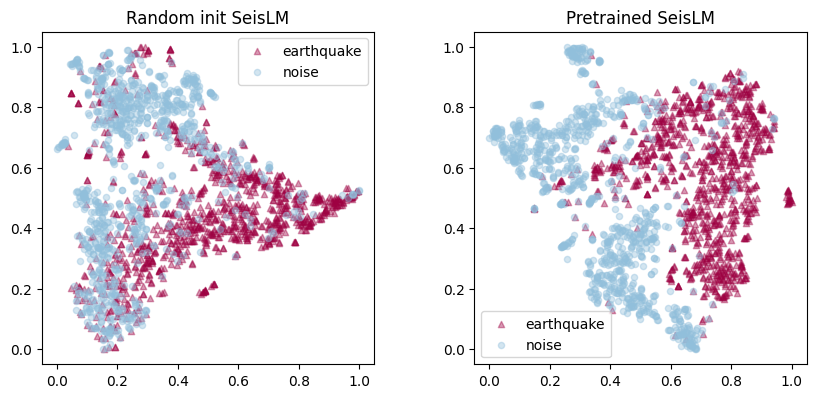

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Configuration and constants
markers = {'noise': 'o', 'earthquake': '^'}
a4_width = 8.27
fig_width = a4_width
fig_height = fig_width / 2
marker_size = 20
show_all_trace_indices = False
trace_indices = [1600, 1400, 600, 0]

# Create figure with two subplots side by side
fig, (ax_col1, ax_col2) = plt.subplots(1, 2, figsize=(fig_width, fig_height))

def plot_embeddings(ax, embeddings, trace_type, label, color, marker):
    embedding_of_label = embeddings[np.array(label) == trace_type]
    ax.scatter(*embedding_of_label.T, label=label, marker=marker, s=marker_size, c=color, alpha=0.4, zorder=2)

    if show_all_trace_indices:
        label_indices = np.where(np.array(label) == trace_type)[0]
        embedding_of_label = embeddings[label_indices]
        dot_indices = np.arange(len(embedding_of_label))[::200]
        for dot_index in dot_indices:
            x, y = embedding_of_label[dot_index]
            ax.text(x, y, str(label_indices[dot_index]), fontsize=8, ha='right')

def annotate_traces(ax, embeddings, trace_indices):
    for trace_index in trace_indices:
        x, y = embeddings[trace_index]
        ax.text(x, y, str(trace_index), fontsize=12, ha='right',
                bbox=dict(facecolor='#e0e0e0', edgecolor='none', pad=1))

# Plot for random_init in the first subplot
embeddings_random = MinMaxScaler().fit_transform(embeddings_of_models['random_init']['hidden_states_6'])
# embeddings_random = embeddings_of_models['random_init']['hidden_states_6']
for label, color in zip(['earthquake', 'noise'], ['#9e0142', '#91bfdb']):
    plot_embeddings(ax_col1, embeddings_random, all_trace_types, label, color, markers[label])
# annotate_traces(ax_col1, embeddings_random, trace_indices)
ax_col1.legend()
ax_col1.set_aspect('equal')  # Ensure the scatter plot is square
ax_col1.set_title('Random init SeisLM')

# Plot for pretrained in the second subplot
embeddings_pretrained = MinMaxScaler().fit_transform(embeddings_of_models['pretrained']['hidden_states_6'])
# embeddings_pretrained = embeddings_of_models['pretrained']['hidden_states_6']
for label, color in zip(['earthquake', 'noise'], ['#9e0142', '#91bfdb']):
    plot_embeddings(ax_col2, embeddings_pretrained, all_trace_types, label, color, markers[label])
# annotate_traces(ax_col2, embeddings_pretrained, trace_indices)
ax_col2.legend()
ax_col2.set_aspect('equal')  # Ensure the scatter plot is square
ax_col2.set_title('Pretrained SeisLM')

# Adjust layout for better spacing
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)  # Adjust wspace to control the space between plots
plt.show()
# fig.savefig( project_path.FIGURE_DIR + f'/trace_embedding.pdf')
fig.savefig( project_path.FIGURE_DIR + f'/trace_embedding.png')



# Clustering analysis

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Configuration and constants
markers = {'noise': 'o', 'earthquake': '^'}
a4_width = 8.27
fig_width = a4_width
fig_height = fig_width / 4
marker_size = 20
show_all_trace_indices = False
trace_indices = [1600, 1400, 600, 0]

fig = plt.figure(figsize=(fig_width, fig_height))
gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1, 1])

def plot_embeddings(ax, embeddings, trace_type, label, color, marker):
    embedding_of_label = embeddings[np.array(label) == trace_type]
    ax.scatter(*embedding_of_label.T, label=label, marker=marker, s=marker_size, c=color, alpha=0.4, zorder=2)

    if show_all_trace_indices:
        label_indices = np.where(np.array(label) == trace_type)[0]
        embedding_of_label = embeddings[label_indices]
        dot_indices = np.arange(len(embedding_of_label))[::200]
        for dot_index in dot_indices:
            x, y = embedding_of_label[dot_index]
            ax.text(x, y, str(label_indices[dot_index]), fontsize=8, ha='right')

def annotate_traces(ax, embeddings, trace_indices):
    for trace_index in trace_indices:
        x, y = embeddings[trace_index]
        ax.text(x, y, str(trace_index), fontsize=12, ha='right',
                bbox=dict(facecolor='#e0e0e0', edgecolor='none', pad=1))

# Plot for random_init in the first column
ax_col1 = fig.add_subplot(gs[:, 0])
embeddings_random = MinMaxScaler().fit_transform(embeddings_of_models['random_init']['hidden_states_6'])

for label, color in zip(['earthquake', 'noise'], ['#9e0142', '#91bfdb']):
    plot_embeddings(ax_col1, embeddings_random, all_trace_types, label, color, markers[label])

annotate_traces(ax_col1, embeddings_random, trace_indices)
ax_col1.legend()
ax_col1.set_aspect('equal')  # Ensure the scatter plot is square

# Plot for pretrained in the second column
ax_col2 = fig.add_subplot(gs[:, 1])
embeddings_pretrained = MinMaxScaler().fit_transform(embeddings_of_models['pretrained']['hidden_states_6'])

for label, color in zip(['earthquake', 'noise'], ['#9e0142', '#91bfdb']):
    plot_embeddings(ax_col2, embeddings_pretrained, all_trace_types, label, color, markers[label])

annotate_traces(ax_col2, embeddings_pretrained, trace_indices)
ax_col2.legend()
ax_col2.set_aspect('equal')  # Ensure the scatter plot is square

# Plot the smaller trace plots in the last two columns
ax_trace1 = fig.add_subplot(gs[0, 2])
ax_trace2 = fig.add_subplot(gs[1, 2])
ax_trace3 = fig.add_subplot(gs[0, 3])
ax_trace4 = fig.add_subplot(gs[1, 3])

trace_plot_axes = [ax_trace1, ax_trace2, ax_trace3, ax_trace4]
trace_titles = [
    f'Noise trace {trace_indices[0]}',
    f'Noise trace {trace_indices[1]}',
    f'Earthquake trace {trace_indices[2]}',
    f'Earthquake trace {trace_indices[3]}'
]

for ax, trace_idx, title in zip(trace_plot_axes, trace_indices, trace_titles):
    ax.set_title(title)
    ax.plot(all_input_values['X'][trace_idx].T)

# Adjust layout for better spacing
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=1.2)  # Adjust these values as needed
plt.show()


NameError: name 'gridspec' is not defined

<Figure size 827x206.75 with 0 Axes>

In [ ]:


batch = next(iter(loader))


2024-08-29 16:01:58,774 | seisbench | WARNING | Traces can not uniformly be identified using name. "get_idx_from_trace_name" will return only one possible matching trace.


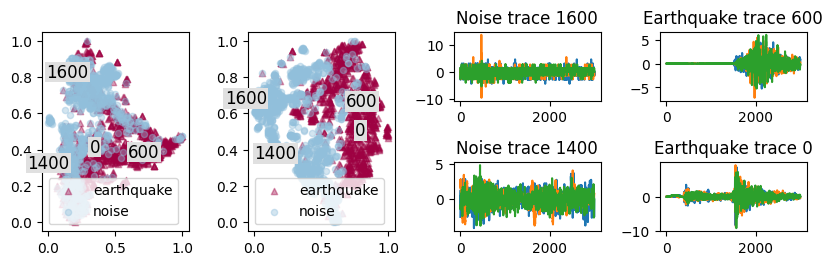

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

markers = {
  'noise': 'o',
  'earthquake': '^',
}


all_trace_types = all_input_values['trace_type']

a4_width = 8.27
fig_width = a4_width
fig_height = fig_width / 3

marker_size = 20


show_all_trace_indices = False
# Create a figure with the specified size
fig = plt.figure(figsize=(fig_width, fig_height))

# Create a GridSpec with 4 rows and 3 columns
# The width ratios for the columns are equal
# The height ratios ensure the last column is divided into 4 panels
gs = gridspec.GridSpec(4, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1, 1])


embeddings = MinMaxScaler().fit_transform(embeddings_of_models['random_init']['hidden_states_6'])

ax_col1 = fig.add_subplot(gs[:, 0])  # Spans all rows in the first column
for k, label in enumerate(['earthquake', 'noise']):
  embedding_of_label = embeddings[ np.array(label) == all_trace_types]
  if label == 'earthquake':
    ax_col1.scatter(
      *embedding_of_label.T,
      label=label,
      marker=markers[label],
      s=marker_size,
      c='#9e0142',
      alpha=0.4,
      zorder=2,
    )
  else:
    ax_col1.scatter(
      *embedding_of_label.T,
      label=label,
      marker=markers[label],
      s=marker_size,
      c='#91bfdb',
      alpha=0.4,
      zorder=2,
    )

  label_indices = np.where(np.array(label) == all_trace_types)[0]
  embedding_of_label = embeddings[label_indices]
  dot_indices = np.arange(len(embedding_of_label))[::200]

  if show_all_trace_indices:
    for dot_index in dot_indices:
      x, y = embedding_of_label[dot_index]
      ax_col1.text(x, y, str(label_indices[dot_index]), fontsize=8, ha='right')

# ax_col1.set_title('TSNE of trace embeddings of pretrained SeisLM')
trace_indices = [1600, 1400, 600, 0]

for trace_index in trace_indices:
  x, y = embeddings[trace_index]
  ax_col1.text(
        x, y, str(trace_index),
        fontsize=12,
        ha='right',
        bbox=dict(facecolor='#e0e0e0', edgecolor='none', pad=1)  # Adding a white background
  )
  ax_col1.legend()


ax_col2 = fig.add_subplot(gs[:, 1])  # Spans all rows in the first column
embeddings = MinMaxScaler().fit_transform(embeddings_of_models['pretrained']['hidden_states_6'])

for k, label in enumerate(['earthquake', 'noise']):
  embedding_of_label = embeddings[ np.array(label) == all_trace_types]

  if label == 'earthquake':
    # Use Reds_r so that smaller values are darker
    cmap = plt.cm.Reds_r
    ax_col2.scatter(
      *embedding_of_label.T,
      label=label,
      marker=markers[label],
      s=marker_size,
      c='#9e0142',
      alpha=0.4,
      zorder=2,
    )
  else:
    # Use Blues_r so that greater values are darker
    ax_col2.scatter(
      *embedding_of_label.T,
      label=label,
      marker=markers[label],
      s=marker_size,
      c='#91bfdb',
      alpha=0.4,
      zorder=2,
    )

  label_indices = np.where(np.array(label) == all_trace_types)[0]
  embedding_of_label = embeddings[label_indices]
  dot_indices = np.arange(len(embedding_of_label))[::200]

  if show_all_trace_indices:
    for dot_index in dot_indices:
      x, y = embedding_of_label[dot_index]
      ax_col2.text(x, y, str(label_indices[dot_index]), fontsize=8, ha='right')


for trace_index in trace_indices:
  x, y = embeddings[trace_index]
  # ax1.text(x, y, str(trace_index), fontsize=12, ha='right')
  ax_col2.text(
        x, y, str(trace_index),
        fontsize=12,
        ha='right',
        bbox=dict(facecolor='#e0e0e0', edgecolor='none', pad=1)  # Adding a white background
  )
  ax_col2.legend()


# Create the four smaller plots (in the second column)
trace_idx = trace_indices[0]
ax2 = fig.add_subplot(gs[0:2, 2])  # First row, second column
ax2.set_title(f'Noise trace {trace_idx}')
ax2.plot(all_input_values['X'][trace_idx].T)  # Example plot


trace_idx = trace_indices[1]
ax3 = fig.add_subplot(gs[2:4, 2])  # Second row, second column
ax3.set_title(f'Noise trace {trace_idx}')
ax3.plot(all_input_values['X'][trace_idx].T)  # Example plot

trace_idx = trace_indices[2]
ax4 = fig.add_subplot(gs[0:2, 3])  # Third row, second column
ax4.set_title(f'Earthquake trace {trace_idx}')
ax4.plot(all_input_values['X'][trace_idx].T)  # Example plot

trace_idx = trace_indices[3]
ax5 = fig.add_subplot(gs[2:4, 3])
ax5.set_title(f'Earthquake trace {trace_idx}')
ax5.plot(all_input_values['X'][trace_idx].T)  # Example plot


# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
gs

GridSpec(4, 3)

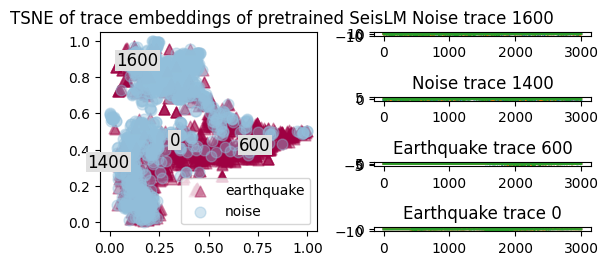

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

markers = {
  'noise': 'o',
  'earthquake': '^',
}


all_trace_types = all_input_values['trace_type']
embeddings = embedding_dict['hidden_states_6']

embeddings = MinMaxScaler().fit_transform(embeddings)


# Create a figure with a specific size
fig = plt.figure(figsize=(10, 6))

# Create a GridSpec with 3 rows and 2 columns
gs = gridspec.GridSpec(4, 2, width_ratios=[2, 2], height_ratios=[1, 1, 1, 1])

# Create the square plot (spanning 3 rows in the first column)
ax1 = fig.add_subplot(gs[:, 0])  # Spans all rows in the first column
for k, label in enumerate(['earthquake', 'noise']):
  embedding_of_label = embeddings[ np.array(label) == all_trace_types]
  # path_ep_distance_km_of_label = all_input_values['path_ep_distance_km'][np.array(label) == all_trace_types]
  path_hyp_distance_km_of_label = all_input_values['path_hyp_distance_km'][np.array(label) == all_trace_types]
  norm = plt.Normalize(vmin=path_hyp_distance_km_of_label.min(), vmax=path_hyp_distance_km_of_label.max())

  if label == 'earthquake':
    # Use Reds_r so that smaller values are darker
    cmap = plt.cm.Reds_r
    ax1.scatter(
      *embedding_of_label.T,
      label=label,
      marker=markers[label],
      s=60,
      c='#9e0142',
      # c=path_hyp_distance_km_of_label,  # Use the array for coloring
      # cmap=cmap,  # You can choose any colormap you like
      # norm=norm,  # Apply normalization (optional)
      alpha=0.4,
      zorder=2,
    )
  else:
    # Use Blues_r so that greater values are darker
    cmap = plt.cm.Blues_r
    norm = plt.Normalize(vmin=path_hyp_distance_km_of_label.min(), vmax=path_hyp_distance_km_of_label.max())
    ax1.scatter(
      *embedding_of_label.T,
      label=label,
      marker=markers[label],
      s=60,
      # norm=norm,
      c='#91bfdb',
      # c=path_hyp_distance_km_of_label,  # Use the array for coloring
      # cmap=cmap,  # You can choose any colormap you like
      alpha=0.4,
      zorder=2,
    )

  label_indices = np.where(np.array(label) == all_trace_types)[0]
  embedding_of_label = embeddings[label_indices]
  dot_indices = np.arange(len(embedding_of_label))[::200]

  # for dot_index in dot_indices:
  #   x, y = embedding_of_label[dot_index]
  #   ax1.text(x, y, str(label_indices[dot_index]), fontsize=8, ha='right')
  # ax1.legend()



ax1.set_title('TSNE of trace embeddings of pretrained SeisLM')
trace_indices = [1600, 1400, 600, 0]

for trace_index in trace_indices:
  x, y = embeddings[trace_index]
  # ax1.text(x, y, str(trace_index), fontsize=12, ha='right')
  ax1.text(
        x, y, str(trace_index),
        fontsize=12,
        ha='right',
        bbox=dict(facecolor='#e0e0e0', edgecolor='none', pad=1)  # Adding a white background
  )
  ax1.legend()


# Create the four smaller plots (in the second column)
trace_idx = trace_indices[0]
ax2 = fig.add_subplot(gs[0, 1])  # First row, second column
ax2.set_title(f'Noise trace {trace_idx}')
ax2.plot(all_input_values['X'][trace_idx].T)  # Example plot


trace_idx = trace_indices[1]
ax3 = fig.add_subplot(gs[1, 1])  # Second row, second column
ax3.set_title(f'Noise trace {trace_idx}')
ax3.plot(all_input_values['X'][trace_idx].T)  # Example plot

trace_idx = trace_indices[2]
ax4 = fig.add_subplot(gs[2, 1])  # Third row, second column
ax4.set_title(f'Earthquake trace {trace_idx}')
ax4.plot(all_input_values['X'][trace_idx].T)  # Example plot

trace_idx = trace_indices[3]
ax5 = fig.add_subplot(gs[3, 1])
ax5.set_title(f'Earthquake trace {trace_idx}')
ax5.plot(all_input_values['X'][trace_idx].T)  # Example plot


# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

